In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2

In [3]:
class DummyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet50(pretrained=True)
        self.extractor = correspondence_datamodule.ResnetActivationExtractor(self.model)
        self.encoded_channels=1024
    
    def forward(self, image):
        a = self.extractor(image)
        return {
            'early': a['layer3_conv3'],
            'middle': a['layer3_conv3'],
            'deep': a['layer3_conv3'],
        }

torch.Size([1930])


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


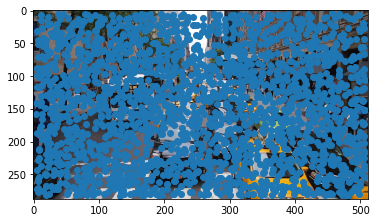

In [4]:
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3)
image = Image.open('/home/mark/Downloads/test.jpg')
image_np = np.array(image)
image = utils.preprocess_image(image_np)
image = torch.as_tensor(image)
image = torch.unsqueeze(image, 0)

keypoints, descriptors, scores = extraction_model(image)

print(scores.size())

plt.imshow(image_np)
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.show()

In [61]:
pair_idx = 1
assert(pair_idx in [1, 2, 3])
pair_path = os.path.join('qualitative/images', f'pair_{pair_idx}')

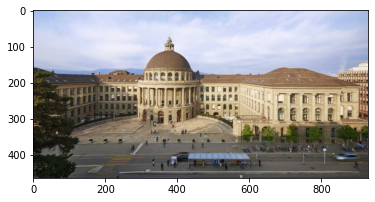

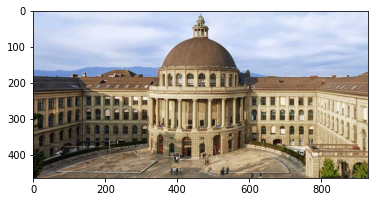

In [62]:
img = Image.open(os.path.join(pair_path, '1.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image1_np = np.array(img)
img = Image.open(os.path.join(pair_path, '2.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image2_np = np.array(img)
image1 = utils.preprocess_image(image1_np)
image1 = torch.as_tensor(image1)
image1 = torch.unsqueeze(image1, 0)
image2 = utils.preprocess_image(image2_np)
image2 = torch.as_tensor(image2)
image2 = torch.unsqueeze(image2, 0)

plt.imshow(image1_np)
plt.show()
plt.imshow(image2_np)
plt.show()

In [69]:
encoder = DummyEncoder().eval()
attention = attention_model.MultiAttentionLayer(encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=4, thresh=0.9)

In [70]:
kp1, descr1, scores1 = extraction_model(image1)
kp2, descr2, scores2 = extraction_model(image2)

# For dummy encoder, we get 3 times the same output
s1 = scores1.size()[0] #// 3
print(f'{scores1.size()[0]} --> {s1}')
kp1 = kp1[:s1, :].numpy()
descr1 = descr1[:s1, :].numpy()
scores1 = scores1[:s1]

s2 = scores2.size()[0] #// 3
print(f'{scores2.size()[0]} --> {s2}')
kp2 = kp2[:s2, :].numpy()
descr2 = descr2[:s2, :].numpy()
scores2 = scores2[:s2]

print(scores1)
print(scores2)

347 --> 347
420 --> 420
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 

In [74]:
matches = match_descriptors(descr1, descr2, cross_check=False)
n_matches = len(matches)
print(len(matches))

347


In [75]:
keypoints_left = kp1[matches[:, 0], : 2]
keypoints_right = kp2[matches[:, 1], : 2]
print(keypoints_left)
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

[[700.5438     77.69645  ]
 [224.6495     85.85544  ]
 [183.14128    72.5157   ]
 [235.85707    77.070496 ]
 [424.77097    67.97713  ]
 [653.84393    78.186874 ]
 [520.466     232.60225  ]
 [412.96155   108.17999  ]
 [566.0025     93.10033  ]
 [242.20354    86.10859  ]
 [213.46259   108.7123   ]
 [414.43842    84.64627  ]
 [636.8863     84.89115  ]
 [164.58577    73.01126  ]
 [590.7139     92.4399   ]
 [612.32526   239.36853  ]
 [913.4638    172.6757   ]
 [668.6306    248.78581  ]
 [316.78143   206.37782  ]
 [698.7686    298.64236  ]
 [489.87027   101.502846 ]
 [643.5563    251.38191  ]
 [729.52527   104.8346   ]
 [600.48724   239.65927  ]
 [550.45795   248.86873  ]
 [779.3453     81.69663  ]
 [333.21866   211.6949   ]
 [713.5457    104.252396 ]
 [606.11066   128.36569  ]
 [847.7799    262.53998  ]
 [179.53001    30.463411 ]
 [714.68964   117.87845  ]
 [593.6021    124.955635 ]
 [517.72375   119.324234 ]
 [324.79907   115.37193  ]
 [426.7739    123.28907  ]
 [494.5517    133.30956  ]
 

Number of inliers: 17.


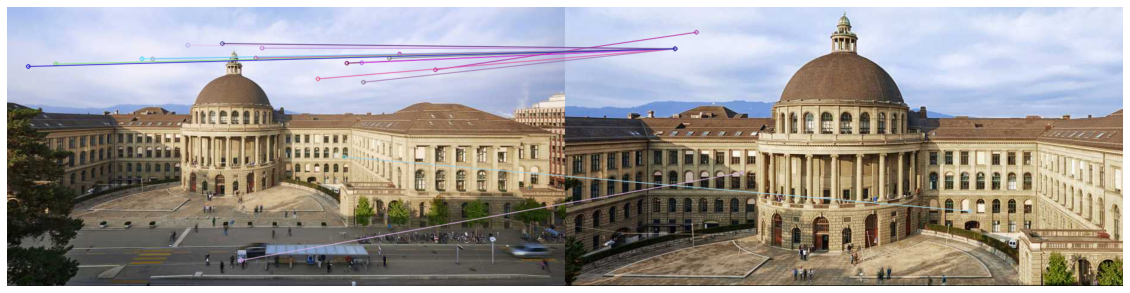

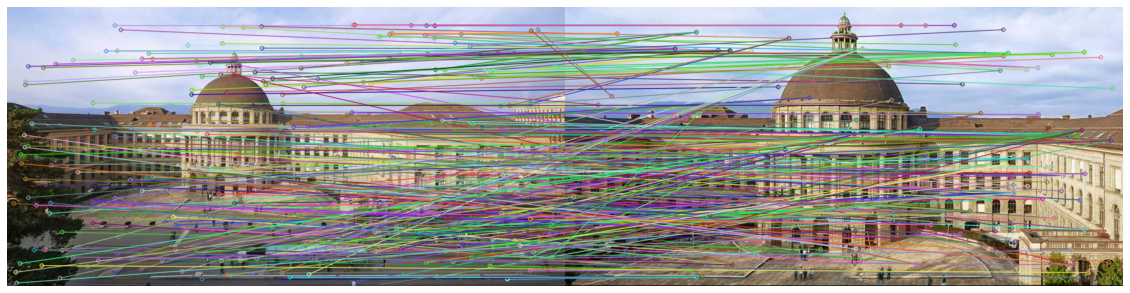

In [76]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image3)
plt.axis('off')
plt.show()

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
image4 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image4)
plt.axis('off')
plt.show()